In [28]:
import json
from datetime import datetime

def convert_timestamps_in_json(json_data):
    # Helper function to convert a single Unix timestamp
    def convert_timestamp(timestamp_ms):
        timestamp_s = timestamp_ms / 1000
        dt_object = datetime.fromtimestamp(timestamp_s)
        return dt_object.strftime('%Y-%m-%d %H:%M:%S')  # Convert to string
    
    # Iterate through the JSON data and replace timestamps
    for entry in json_data:
        if 'soundcloudLog' in entry and 'logTime' in entry['soundcloudLog']:
            timestamp_ms = entry['soundcloudLog']['logTime']
            # Replace the timestamp with the converted datetime string
            entry['soundcloudLog']['logTime'] = convert_timestamp(timestamp_ms)
    
    return json_data

# Load JSON file
with open('soundcloudLogs.json', 'r') as file:
    json_data = json.load(file)

# Convert timestamps
processed_data = convert_timestamps_in_json(json_data)

# Save the processed data to a new JSON file
with open('processed_data.json', 'w') as file:
    json.dump(processed_data, file, indent=4)

print("Timestamps have been converted and saved to 'processed_data.json'.")


Timestamps have been converted and saved to 'processed_data.json'.


In [5]:
import json
import matplotlib.pyplot as plt

# Function to group logs by track name and collect counts over time
def group_logs_and_collect_counts(data):
    grouped_logs = {}
    for item in data:
        name = item.get('name', 'Unknown')
        log = item.get('soundcloudLog', {})
        if name not in grouped_logs:
            grouped_logs[name] = []
        grouped_logs[name].append(log)
    
    # Sort logs by logTime and extract counts
    counts_by_name = {}
    for name, logs in grouped_logs.items():
        logs.sort(key=lambda x: x['logTime'])
        counts_by_name[name] = [log['counts'] for log in logs]
    
    return counts_by_name



In [38]:

# Load the JSON data from a file
with open('soundcloudLogs.json', 'r') as file:
    data = json.load(file)

# Function to group logs by track name and collect counts over time
def group_logs_and_collect_counts(data):
    grouped_logs = {}
    for item in data:
        name = item.get('name', 'Unknown')
        log = item.get('soundcloudLog', {})
        if name not in grouped_logs:
            grouped_logs[name] = []
        grouped_logs[name].append(log)
    
    # Sort logs by logTime and extract counts
    counts_by_name = {}
    for name, logs in grouped_logs.items():
        logs.sort(key=lambda x: x['logTime'])
        counts_by_name[name] = [(log['logTime'], log['counts']) for log in logs]
    
    return counts_by_name

# Group logs and collect counts
counts_by_name = group_logs_and_collect_counts(data)

# Plot counts for each song
'''
for name, counts in counts_by_name.items():
    log_times = [log_time for log_time, _ in counts]
    log_counts = [count for _, count in counts]
    plt.figure(figsize=(10, 5))
    plt.plot(log_times, log_counts, marker='o')
    plt.title(f"Counts over Time for '{name}'")
    plt.xlabel("Log Time")
    plt.ylabel("Counts")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

'''

    

'\nfor name, counts in counts_by_name.items():\n    log_times = [log_time for log_time, _ in counts]\n    log_counts = [count for _, count in counts]\n    plt.figure(figsize=(10, 5))\n    plt.plot(log_times, log_counts, marker=\'o\')\n    plt.title(f"Counts over Time for \'{name}\'")\n    plt.xlabel("Log Time")\n    plt.ylabel("Counts")\n    plt.grid(True)\n    plt.xticks(rotation=45)\n    plt.tight_layout()\n    plt.show()\n\n'

## LSTM

In [143]:
from tensorflow.keras.layers import Input

def lstm_predict(counts, steps=1):
    count_values = np.array([count for _, count in counts])
    scaler = MinMaxScaler(feature_range=(0, 1))
    count_values_scaled = scaler.fit_transform(count_values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(count_values_scaled)-1):
        X.append(count_values_scaled[i])
        y.append(count_values_scaled[i + 1])
    
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(Input(shape=(1, X.shape[2])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=100, batch_size=1, verbose=0)
    
    last_value = count_values_scaled[-1].reshape(1, 1, 1)
    predictions = []
    
    for _ in range(steps):
        predicted_value = model.predict(last_value)
        predictions.append(predicted_value[0][0])
        last_value = np.array([predicted_value]).reshape(1, 1, 1)
    
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions.flatten()


## ETS

In [144]:
def ets_predict(counts, steps=1):
    count_values = [count for _, count in counts]
    model = ExponentialSmoothing(count_values, trend='add', seasonal='add', seasonal_periods=12)
    model_fit = model.fit(optimized=True)
    forecast = model_fit.forecast(steps=steps)
    return forecast


## Prophet Implementation

In [132]:
from prophet import Prophet

def prophet_predict(counts, steps=1):
    df = pd.DataFrame(counts, columns=['ds', 'y'])
    df['ds'] = pd.to_datetime(df['ds'], unit='ms')
    
    model = Prophet()
    model.fit(df)
    
    future = model.make_future_dataframe(periods=steps)
    forecast = model.predict(future)
    
    return forecast['yhat'].tail(steps).values


## GARCH

In [145]:
def garch_predict(counts, steps=1):
    count_values = np.array([count for _, count in counts])
    count_values_rescaled = count_values * 0.0001  # Rescale the data
    model = arch_model(count_values_rescaled, vol='Garch', p=1, q=1, rescale=False)
    model_fit = model.fit(disp="off")
    forecast = model_fit.forecast(horizon=steps)
    
    return forecast.mean.values[-1] * 10000  # Re-adjust the scale of predictions


## TBATS

In [134]:
from tbats import TBATS

def tbats_predict(counts, steps=1):
    count_values = [count for _, count in counts]
    model = TBATS()
    model_fit = model.fit(count_values)
    forecast = model_fit.forecast(steps=steps)
    
    return forecast


## VAR

In [146]:
def var_predict(counts, steps=1):
    count_values = np.array([count for _, count in counts])
    if count_values.ndim == 1:
        raise ValueError("VAR requires multiple time series. Consider using ARIMA or SARIMA instead.")
    model = VAR(count_values)
    model_fit = model.fit()
    forecast = model_fit.forecast(count_values[-model_fit.k_ar:], steps=steps)
    
    return forecast.flatten()


## XGBOSST

In [147]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

def xgboost_predict(counts, steps=1):
    count_values = np.array([count for _, count in counts])
    X = np.arange(len(count_values)).reshape(-1, 1)
    y = count_values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    
    last_value = X[-1]
    predictions = []
    
    for _ in range(steps):
        last_value += 1
        prediction = model.predict(last_value.reshape(-1, 1))
        predictions.append(prediction[0])
    
    return np.array(predictions)


## ARIMA

In [148]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

def arima_predict(counts, order, steps=1):
    # Extract the count values
    count_values = [count for _, count in counts]
    
    # Fit the ARIMA model
    try:
        model = ARIMA(count_values, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=steps)
        return forecast
    except Exception as e:
        print(f"Error fitting ARIMA model: {e}")
        return None

## SARIMA

In [149]:


def sarima_predict(counts, order, seasonal_order, steps=1):
    # Extract the count values
    count_values = [count for _, count in counts]
    
    # Fit the SARIMA model
    try:
        model = SARIMAX(count_values, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=steps)
        return forecast
    except Exception as e:
        print(f"Error fitting SARIMA model: {e}")
        return None


# TEST

In [153]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_predictions_for_track(track_name, counts_by_name, steps=5, arima_order=(5,1,0), sarima_order=(1,1,1,12), seasonal_order=(1,1,1,12)):
    counts = counts_by_name[track_name]

    # Convert Unix timestamps to datetime objects
    log_times = [datetime.fromtimestamp(log_time / 1000) for log_time, _ in counts]
    log_counts = [count for _, count in counts]

    # Generate predictions from various models
    try:
        arima_forecast = arima_predict(counts, order=arima_order, steps=steps)
    except Exception as e:
        print(f"Error fitting ARIMA model: {e}")
        arima_forecast = None

    try:
        sarima_forecast = sarima_predict(counts, order=sarima_order, seasonal_order=seasonal_order, steps=steps)
    except Exception as e:
        print(f"Error fitting SARIMA model: {e}")
        sarima_forecast = None

    try:
        lstm_forecast = lstm_predict(counts, steps=steps)
    except Exception as e:
        print(f"Error fitting LSTM model: {e}")
        lstm_forecast = None

    try:
        ets_forecast = ets_predict(counts, steps=steps)
    except Exception as e:
        print(f"Error fitting ETS model: {e}")
        ets_forecast = None

    try:
        prophet_forecast = prophet_predict(counts, steps=steps)
    except Exception as e:
        print(f"Error fitting Prophet model: {e}")
        prophet_forecast = None

    try:
        garch_forecast = garch_predict(counts, steps=steps)
    except Exception as e:
        print(f"Error fitting GARCH model: {e}")
        garch_forecast = None

    try:
        tbats_forecast = tbats_predict(counts, steps=steps)
    except Exception as e:
        print(f"Error fitting TBATS model: {e}")
        tbats_forecast = None

    try:
        xgboost_forecast = xgboost_predict(counts, steps=steps)
    except Exception as e:
        print(f"Error fitting XGBoost model: {e}")
        xgboost_forecast = None

    # Plot actual data
    plt.figure(figsize=(14, 7))
    plt.plot(log_times, log_counts, label='Actual', marker='o', color='black')

    # Plot ARIMA predictions
    if arima_forecast is not None:
        plt.plot([log_times[-1] + pd.Timedelta(days=i) for i in range(1, steps+1)], arima_forecast, label='ARIMA', marker='o', color='blue')

    # Plot SARIMA predictions
    if sarima_forecast is not None:
        plt.plot([log_times[-1] + pd.Timedelta(days=i) for i in range(1, steps+1)], sarima_forecast, label='SARIMA', marker='o', color='green')

    # Plot LSTM predictions
    if lstm_forecast is not None:
        plt.plot([log_times[-1] + pd.Timedelta(days=i) for i in range(1, steps+1)], lstm_forecast, label='LSTM', marker='o', color='red')

    # Plot ETS predictions
    if ets_forecast is not None:
        plt.plot([log_times[-1] + pd.Timedelta(days=i) for i in range(1, steps+1)], ets_forecast, label='ETS', marker='o', color='orange')

    # Plot Prophet predictions
    if prophet_forecast is not None:
        plt.plot([log_times[-1] + pd.Timedelta(days=i) for i in range(1, steps+1)], prophet_forecast, label='Prophet', marker='o', color='purple')

    # Plot GARCH predictions
    if garch_forecast is not None:
        plt.plot([log_times[-1] + pd.Timedelta(days=i) for i in range(1, steps+1)], garch_forecast, label='GARCH', marker='o', color='cyan')

    # Plot TBATS predictions
    if tbats_forecast is not None:
        plt.plot([log_times[-1] + pd.Timedelta(days=i) for i in range(1, steps+1)], tbats_forecast, label='TBATS', marker='o', color='magenta')

    # Plot XGBoost predictions
    if xgboost_forecast is not None:
        plt.plot([log_times[-1] + pd.Timedelta(days=i) for i in range(1, steps+1)], xgboost_forecast, label='XGBoost', marker='o', color='brown')

    plt.title(f"Predictions for {track_name}")
    plt.xlabel("Time")
    plt.ylabel("Counts")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


In [154]:
counts_by_name = group_logs_and_collect_counts(data)


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Error fitting SARIMA model: `order` argument must be an iterable with three elements.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
23:54:25 - cmdstanpy - INFO - Chain [1] start processing
23:54:40 - cmdstanpy - INFO - Chain [1] done processing


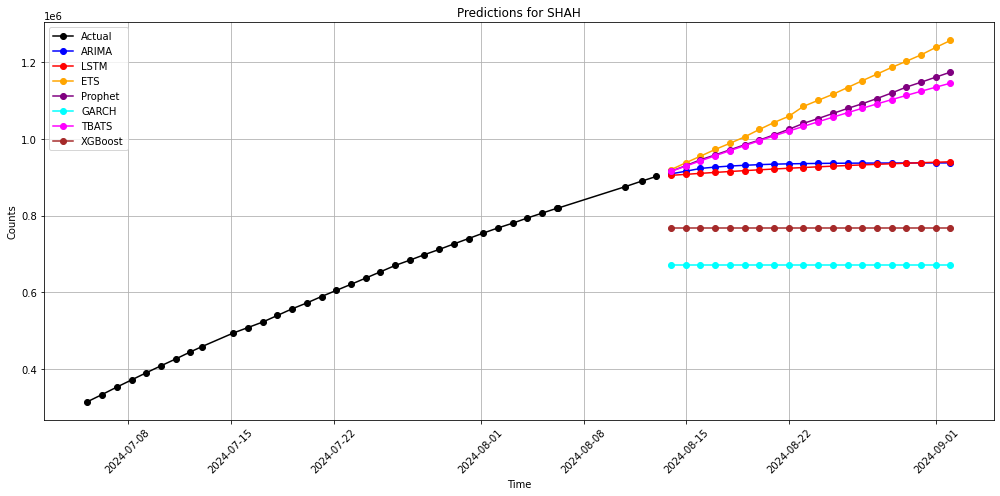

In [159]:
plot_predictions_for_track("SHAH", counts_by_name, steps=20)
